<p style="font-size:300%; background-color:pink; color:blue; text-align:center;line-height : 80px; margin : 0; padding : 0;">
Taller 8: Sistemas difusos en visión de máquina</p>
<p style="font-size:240%; background-color:pink; color:red; text-align:center;line-height : 60px; margin : 0; padding : 0;">
    
Técnicas de Inteligencia Artificial - Visión de Máquina </p1>

<p style="font-size:200%; text-align:center; line-height : 40px;  margin-top : 0; margin-bottom : 0; "> 
  <br>Est. Brian Camilo Valencia Peña (bcvalenciap@unal.edu.co)
  <br>Est. Esteban Ladino Fajardo (eladinof@unal.edu.co)
</p>

<p style="font-size:180%; text-align:center; line-height : 30px;  margin-top : 0; margin-bottom : 0; "> <br><br>INGENIERÍA ELECTRÓNICA</p>
<p style="font-size:180%; text-align:center; line-height : 30px; margin-top : 0; "> Facultad de Ingeniería</p>
<p style="font-size:160%; text-align:center; line-height : 30px; margin-top : 0; "> Universidad Nacional de Colombia Sede Bogotá</p>
<br>
<img src="figs/Escudo_UN.png",width=100,height=100>

<p style="font-size:160%; text-align:center; line-height : 30px; margin-top : 0; "> <br>20 de Junio de 2022</p>

## Enunciado

1. Estudiar las funciones en API Reference, de la biblioteca
Scikit-Fuzzy. http://pythonhosted.org/scikit-fuzzy/api/api.html


2.  Estudiar el ejemplo: Fuzzy Control Systems: The Tipping Problem, en la misma biblioteca.





Source code for skfuzzy.filters.fire
fire2d
2-D filtering using Fuzzy Inference Ruled by Else-action (FIRE)

FIRE filtering is nonlinear, and is specifically designed to remove impulse (salt and pepper) noise.

http://pythonhosted.org/scikit-fuzzy/api/skfuzzy.filters.html

Fabrizio Russo, Fuzzy Filtering of Noisy Sensor Data, IEEE Instrumentation and Measurement Technology Conference, Brussels, Belgium, June 4 - 6, 1996, pp 1281 - 1285.

Función
* http://pythonhosted.org/scikit-fuzzy/_modules/skfuzzy/filters/fire.html


In [1]:
##Parametros
#  I : vector 2d  * imagen de entrada.
#  l2 : float limite maximo de rango de filtrado
#  fuzzyresolution : float, default = 1
##Returns:
# J : vector2d  * imagen filtrada
# ##NOTA
# El filtrado ocurre cuando  l1<|x|<l2 ; fuera de este rango no se aplica.

from __future__ import division, print_function
import numpy as np
import matplotlib.pyplot as plt
import skfuzzy as fuzz

import cv2
%matplotlib inline

import os

def noisy(noise_typ,image):
    if noise_typ == "gauss":
        row,col,ch= image.shape
        mean = 0
        var = 0.1
        sigma = var**0.5
        gauss = np.random.normal(mean,sigma,(row,col,ch))
        gauss = gauss.reshape(row,col,ch)
        noisy = image + gauss
        return noisy
    elif noise_typ == "s&p":
        row,col,ch = image.shape
        s_vs_p = 0.5
        amount = 0.004
        out = np.copy(image)
        # Salt mode
        num_salt = np.ceil(amount * image.size * s_vs_p)
        coords = [np.random.randint(0, i - 1, int(num_salt))
              for i in image.shape]
        out[coords] = 1

        # Pepper mode
        num_pepper = np.ceil(amount* image.size * (1. - s_vs_p))
        coords = [np.random.randint(0, i - 1, int(num_pepper))
              for i in image.shape]
        out[coords] = 0
        return out
    elif noise_typ == "poisson":
        vals = len(np.unique(image))
        vals = 2 ** np.ceil(np.log2(vals))
        noisy = np.random.poisson(image * vals) / float(vals)
        return noisy
    elif noise_typ =="speckle":
        row,col,ch = image.shape
        gauss = np.random.randn(row,col,ch)
        gauss = gauss.reshape(row,col,ch)        
        noisy = image + image * gauss
        return noisy



Funcion noisy
La función agrega ruido gaussiano, salpimienta, poisson y moteado en una imagen. Esto se hace con el obj de aplicarle posteriormente los filtros de logica difusa a la imagen y limpiarla.

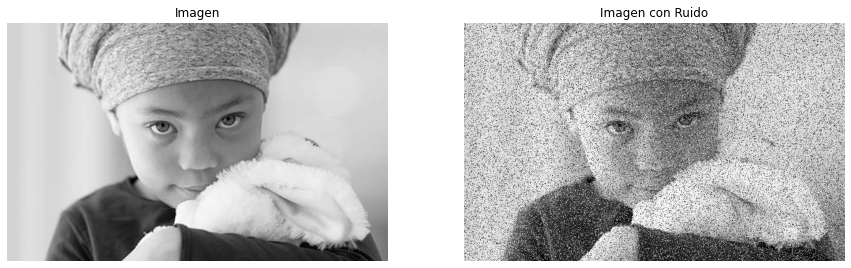

In [3]:
def sp_noise(image, prob):
    '''
    Add salt and pepper noise to image
    prob: Probability of the noise
    '''
    output = image.copy()
    if len(image.shape) == 2:
        black = 0
        white = 255            
    else:
        colorspace = image.shape[2]
        if colorspace == 3:  # RGB
            black = np.array([0, 0, 0], dtype='uint8')
            white = np.array([255, 255, 255], dtype='uint8')
        else:  # RGBA
            black = np.array([0, 0, 0, 255], dtype='uint8')
            white = np.array([255, 255, 255, 255], dtype='uint8')
    probs = np.random.random(output.shape[:2])
    output[probs < (prob / 2)] = black
    output[probs > 1 - (prob / 2)] = white
    return output

img = cv2.imread('figs/imag.jpg',1)
img1 = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#
noise_img = sp_noise(img1,0.2)
#noise_img = noisy("s&p",img)
#img2 = cv2.cvtColor(noise_img, cv2.COLOR_BGR2GRAY)

plt.figure(1,figsize=(15,15))
plt.subplot(221), plt.imshow(img1, cmap='gray'), plt.title('Imagen'), plt.axis("off")
plt.subplot(222), plt.imshow(noise_img, cmap='gray'), plt.title('Imagen con Ruido'), plt.axis("off")
plt.show()



Text(0.5, 1.0, 'Test data: 200 points x3 clusters.')

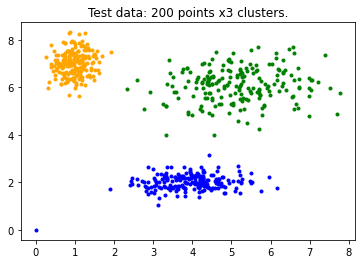

In [4]:
from __future__ import division, print_function
import numpy as np
import matplotlib.pyplot as plt
import skfuzzy as fuzz

%matplotlib inline



colors = ['b', 'orange', 'g', 'r', 'c', 'm', 'y', 'k', 'Brown', 'ForestGreen']

# Define los centros de los cluster 
centers = [[4, 2],
           [1, 7],
           [5, 6]]

# Define los cluster sigmas en x e y, respectivamente
sigmas = [[0.8, 0.3],
          [0.3, 0.5],
          [1.1, 0.7]]

# Genera información de prueba
np.random.seed(42)  # Establecer semilla para la reproducibilidad
xpts = np.zeros(1)
ypts = np.zeros(1)
labels = np.zeros(1)
for i, ((xmu, ymu), (xsigma, ysigma)) in enumerate(zip(centers, sigmas)):
    xpts = np.hstack((xpts, np.random.standard_normal(200) * xsigma + xmu))
    ypts = np.hstack((ypts, np.random.standard_normal(200) * ysigma + ymu))
    labels = np.hstack((labels, np.ones(200) * i))

# Visualizar los datos de prueba
fig0, ax0 = plt.subplots()
for label in range(3):
    ax0.plot(xpts[labels == label], ypts[labels == label], '.',
             color=colors[label])
ax0.set_title('Test data: 200 points x3 clusters.')

## Clustering

Arriba están los datos de prueba.
    * Se ven tres manchas distintas.
    * ¿Quizás si los datos no estan tan claramente agrupados?

* A continuación se intenta agrupar los datos varias veces, con entre 2 y 9 grupos.

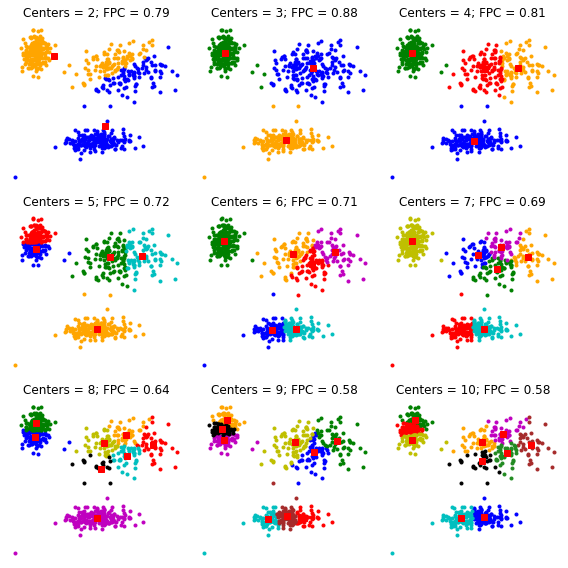

In [5]:
# Configurar el bucle y trazar
fig1, axes1 = plt.subplots(3, 3, figsize=(8, 8))
alldata = np.vstack((xpts, ypts))
fpcs = []

for ncenters, ax in enumerate(axes1.reshape(-1), 2):
    cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
        alldata, ncenters, 2, error=0.005, maxiter=1000, init=None)

    # Almacenar valores fpc para más tarde
    fpcs.append(fpc)

    # Trazar grupos asignados, para cada punto de datos en el conjunto de entrenamiento
    cluster_membership = np.argmax(u, axis=0)
    for j in range(ncenters):
        ax.plot(xpts[cluster_membership == j],
                ypts[cluster_membership == j], '.', color=colors[j])

    # Marcar el centro de cada grupo borroso
    for pt in cntr:
        ax.plot(pt[0], pt[1], 'rs')

    ax.set_title('Centers = {0}; FPC = {1:.2f}'.format(ncenters, fpc))
    ax.axis('off')

fig1.tight_layout()

## El coeficiente de partición difusa (FPC)
Se define en el rango de 0 a 1, siendo 1 el mejor. Es una métrica que indica cuán limpiamente los datos son descritos por un determinado modelo. Luego se muestran los resultados de la agrupación y se traza el coeficiente de partición difusa. Cuando se maximiza el FPC, los datos se describen mejor. 

Tener el FPC disponible puede ser muy útil cuando la estructura de sus datos no está clara. Tenga en cuenta que se comenzó con dos centros, no uno; agrupar un conjunto de datos con un solo centro de clúster es la solución trivial y, por definición, devolverá FPC == 1.


3. Implementar alguno de los siguientes algoritmos que emplean lógica difusa (vistos en clase), como una función de phyton:


    3.1 Detector de bordes difuso3 .

    3.2 Segmentación difusa por umbralización4 .

Text(0, 0.5, 'Fuzzy partition coefficient')

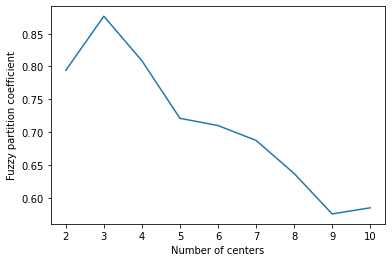

In [6]:
fig2, ax2 = plt.subplots()
ax2.plot(np.r_[2:11], fpcs)
ax2.set_xlabel("Number of centers")
ax2.set_ylabel("Fuzzy partition coefficient")

## Modelo
* Sabemos que nuestro mejor modelo tiene tres centros de conglomerados.
* Reconstruiremos un modelo de 3 grupos para usarlo en la predicción, generar nuevos datos uniformes y predecir a qué grupo pertenece cada nuevo punto de datos.

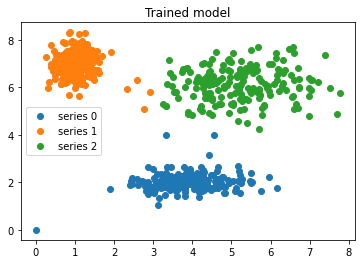

In [7]:
# Regenerar el modelo borroso con 3 centros de conglomerados: tenga en cuenta que el orden de los centros
# es aleatorio en este algoritmo de agrupación, por lo que los centros pueden cambiar de lugar
cntr, u_orig, _, _, _, _, _ = fuzz.cluster.cmeans(
    alldata, 3, 2, error=0.005, maxiter=1000)

# Show 3-cluster model
fig2, ax2 = plt.subplots()
ax2.set_title('Trained model')
for j in range(3):
    ax2.plot(alldata[0, u_orig.argmax(axis=0) == j],
             alldata[1, u_orig.argmax(axis=0) == j], 'o',
             label='series ' + str(j))
ax2.legend()

# Predicción
* Finalmente, generamos datos muestreados uniformemente sobre este campo y los clasificamos a través de cmeans_predict, incorporándolos al modelo preexistente.

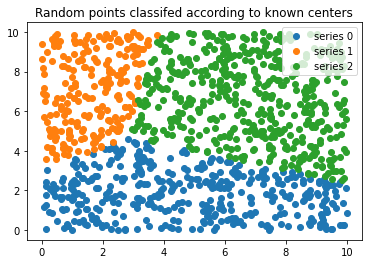

In [8]:
# Genere datos muestreados uniformemente distribuidos en el rango [0, 10] en x e y
newdata = np.random.uniform(0, 1, (1100, 2)) * 10

# Predecir nuevos miembros del clúster con `cmeans_predict` así como
# `cntr`del modelo de 3 clústeres
u, u0, d, jm, p, fpc = fuzz.cluster.cmeans_predict(
    newdata.T, cntr, 2, error=0.005, maxiter=1000)

# Trazar los datos uniformes clasificados. Tenga en cuenta para la visualización el máximo
# valor de membresía se ha tomado en cada punto (es decir, estos se endurecen,
# no se visualizan resultados borrosos) pero el resultado borroso completo es la salida
# from cmeans_predict.
cluster_membership = np.argmax(u, axis=0)  # Hardening for visualization

fig3, ax3 = plt.subplots()
ax3.set_title('Random points classifed according to known centers')
for j in range(3):
    ax3.plot(newdata[cluster_membership == j, 0],
             newdata[cluster_membership == j, 1], 'o',
             label='series ' + str(j))
ax3.legend()

plt.show()

## Desarrollo